In [17]:
import os
import sys
import json
sys.path.append("..")
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_validate, train_test_split, TimeSeriesSplit
import numpy as np
from settings import PROJECT_PATH, CLASSIFICATION_TARGET, REGRESSION_TARGET
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

In [2]:
data = pd.read_parquet(os.path.join(PROJECT_PATH, 'data/interim/transactions_post_feature_engineering.parquet'))

In [12]:
with open ("../preprocessing/features_used/features_name.json", "r") as f :
    features_name = json.load (f)

with open("../preprocessing/features_used/numerical_features.json", "r") as f :
    numerical_features= json.load(f)
print(features_name)
print(numerical_features)

FileNotFoundError: [Errno 2] No such file or directory: '../preprocessing/features_used/features_name.json'

In [4]:
categorial_features = [col for col in features_name if col not in numerical_features and col not in [REGRESSION_TARGET,CLASSIFICATION_TARGET]]
print(categorial_features)

['vefa', 'ville_demandee', 'type_batiment_Maison', 'nom_region_Nouvelle-Aquitaine', 'nom_region_Occitanie', "nom_region_Provence-Alpes-Côte d'Azur", 'nom_region_Île-de-France']


In [13]:
# Copie du Df d'origine
df = data.copy()
# Séparation du Df en trainset et testset
trainset,testset= train_test_split(df, test_size=0.2, random_state=0)

print(f'Nombre d\'échantillons du trainset: {trainset.shape[0]}')
print(f"proportion de biens en dessous du marché dans le trainset:{round(trainset['en_dessous_du_marche'].value_counts(normalize=True)[1],2)}")
print(f'Nombre d\'échantillons du testset: {testset.shape[0]}')
print(f"proportion de biens en dessous du marché dans le testset:{round(testset['en_dessous_du_marche'].value_counts(normalize=True)[1],2)}")

Nombre d'échantillons du trainset: 374492
proportion de biens en dessous du marché dans le trainset:0.37
Nombre d'échantillons du testset: 93623
proportion de biens en dessous du marché dans le testset:0.37


In [14]:
X_train= trainset.drop([REGRESSION_TARGET,CLASSIFICATION_TARGET],axis=1)
y_train_regression = trainset[REGRESSION_TARGET]
y_train_classification = trainset[CLASSIFICATION_TARGET]

In [15]:
X_test= testset.drop([REGRESSION_TARGET,CLASSIFICATION_TARGET],axis=1)
y_test_regression = testset[REGRESSION_TARGET]
y_test_classification = testset[CLASSIFICATION_TARGET]

In [8]:
def perform_cross_validation(
    X: pd.DataFrame,
    y: pd.Series,
    model,
    cross_val_type,
    scoring_metrics: tuple,
    groupes=None,
):
    """
    Effectue une validation croisée pour un modèle donné et retourne les scores
    d'entraînement et de test, ainsi que le modèle ajusté.

    Paramètres :
    ----------
    X : pd.DataFrame
        Les données d'entrée (features) au format pandas DataFrame.
    y : pd.Series
        Les étiquettes ou cibles au format pandas Series.
    modele : object
        Modèle d'apprentissage supervisé (ex : un modèle sklearn) à valider.
    cross_val_type : int, générateur ou objet de type cross-validation
        La stratégie de validation croisée à utiliser (ex : KFold, StratifiedKFold).
    scoring_metrics : tuple
        Les métriques d'évaluation pour la validation croisée
        (ex : ('accuracy', 'f1')).
    groupes : array-like, optionnel
        Groupes utilisés pour certaines stratégies de validation croisée
        comme GroupKFold.

    Retourne :
    ---------
    scores : dict
        Les scores obtenus pour chaque métrique durant la validation croisée.
    scores_dict : dict
        Moyennes et écarts-types des scores pour chaque métrique.
    modele : object
        Le modèle ajusté sur l'ensemble complet des données (X, y).

    Exemple d'appel :
    -----------------
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from sklearn.model_selection import KFold
    >>> X = pd.DataFrame({'feature1': [1, 2, 3], 'feature2': [4, 5, 6]})
    >>> y = pd.Series([0, 1, 0])
    >>> modele = RandomForestClassifier()
    >>> cross_val_type = KFold(n_splits=3)
    >>> scoring_metrics = ('accuracy', 'f1')
    >>> scores, scores_dict, model = effectuer_validation_croisée(X, y, model, cross_val_type, scoring_metrics)
    """
    # Effectuer la validation croisée
    scores = cross_validate(
        model,
        X.values,  # Convertir DataFrame en tableau NumPy
        y.values,  # Convertir Series en tableau NumPy
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=True,
        scoring=scoring_metrics,
        groups=groupes,
    )

    # Calculer les moyennes et écarts-types pour chaque métrique
    scores_dict = {}
    for metrique in scoring_metrics:
        scores_dict["moyenne_train_" + metrique] = np.mean(scores["train_" + metrique])
        scores_dict["ecart_type_train_" + metrique] = np.std(scores["train_" + metrique])
        scores_dict["moyenne_test_" + metrique] = np.mean(scores["test_" + metrique])
        scores_dict["ecart_type_test_" + metrique] = np.std(scores["test_" + metrique])

    # Ajuster le modèle sur l'ensemble des données
    model.fit(X.values, y.values)

    return scores, scores_dict, model

In [6]:
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

In [7]:
mlflow.set_tracking_uri(os.path.join(PROJECT_PATH,"mlruns"))

In [11]:
experiment_name = "regression_models"
experiment_tags = {
        "phase": "Model_Comparison",
        "revision_de_donnees": "v1",
        "date_de_construction": "Janvier 2025"
    }

In [12]:
from mlflow import MlflowClient, set_experiment

def configure_mlflow_experiment(experiment_name: str, experiment_tags: dict = None) -> str:
    """
    Configure une expérience MLflow. Crée l'expérience si elle n'existe pas déjà et la définit comme active.

    Args:
        experiment_name (str): Le nom de l'expérience MLflow.
        experiment_tags (dict, optional): Un dictionnaire de tags pour l'expérience. Par défaut, aucun tag.

    Returns:
        str: L'ID de l'expérience configurée.
    """
    client = MlflowClient()
    try:
        # Tente de créer une nouvelle expérience
        experiment_id = client.create_experiment(name=experiment_name, tags=experiment_tags)
        print(f"Nouvelle expérience créée avec l'ID : {experiment_id}")
    except Exception as e:
        # Si l'expérience existe déjà, récupère son ID
        print(f"L'expérience existe déjà : {str(e)}")
        experiment = client.get_experiment_by_name(experiment_name)
        if experiment is None:
            raise ValueError(f"L'expérience {experiment_name} n'a pas pu être récupérée.")
        experiment_id = experiment.experiment_id

    # Définir l'expérience active
    set_experiment(experiment_name)
    print(f"Expérience définie : {experiment_name} (ID : {experiment_id})")

    return experiment_id


In [13]:

def train_and_log_model_with_mlflow(
    model,
    X_train,
    y_train,
    experiment_name,
    run_name,
    model_params,
    tags,
    cross_val_type,
    scoring_metrics,
    groups=None,
):
    """
    Entraîne un modèle, effectue une validation croisée avec `perform_cross_validation`,
    enregistre les résultats et le modèle avec MLflow.

    Paramètres :
    ----------
    model : object
        Modèle d'apprentissage supervisé (ex : un modèle sklearn).
    X_train : pd.DataFrame
        Les données d'entrée pour l'entraînement.
    y_train : pd.Series
        Les étiquettes ou cibles.
    experiment_name : str
        Nom de l'expérience MLflow.
    run_name : str
        Nom du run dans MLflow.
    model_params : dict
        Paramètres du modèle.
    tags : dict
        Tags à ajouter au run MLflow.
    cross_val_type : int, générateur ou objet de type cross-validation
        La stratégie de validation croisée à utiliser (ex : KFold, StratifiedKFold).
    scoring_metrics : tuple
        Les métriques d'évaluation pour la validation croisée
        (ex : ('accuracy', 'f1')).
    groups : array-like, optionnel
        Groupes utilisés pour certaines stratégies de validation croisée
        comme GroupKFold.

    Retourne :
    ---------
    scores_dict : dict
        Moyennes et écarts-types des scores pour chaque métrique.
    """
    import mlflow
    import mlflow.sklearn

    # Définir ou créer l'expérience MLflow
    from mlflow.tracking import MlflowClient

    client = MlflowClient()
    try:
        experiment_id = client.create_experiment(name=experiment_name)
        print(f"Nouvelle expérience créée avec l'ID : {experiment_id}")
    except Exception:
        experiment = client.get_experiment_by_name(experiment_name)
        experiment_id = experiment.experiment_id

    mlflow.set_experiment(experiment_name)

    # Démarrer un nouveau run dans MLflow
    with mlflow.start_run(run_name=run_name):
        # Ajouter les tags au run
        mlflow.set_tags(tags)

        # Effectuer la validation croisée
        scores, scores_dict, trained_model = perform_cross_validation(
            X=X_train,
            y=y_train,
            model=model,
            cross_val_type=cross_val_type,
            scoring_metrics=scoring_metrics,
            groupes=groups,
        )

        # Enregistrer les paramètres du modèle
        for param_name, param_value in model_params.items():
            mlflow.log_param(param_name, param_value)

        # Enregistrer les métriques
        mlflow.log_metrics(scores_dict)



        # Créer la signature du modèle à partir des données
        signature = infer_signature(X_train, y_train)

        # Exemple d'entrée pour le modèle
        input_example = X_train.head(1)
        mlflow.sklearn.log_model(trained_model, "model", input_example=input_example, signature=signature)

        # Enregistrement du DataFrame d'entraînement en tant qu'artefact
        trainset_file = "trainset.csv"
        X_train.to_csv(trainset_file, index=False)
        mlflow.log_artifact(trainset_file)

        # Retourner les scores
        return scores_dict


In [14]:
configure_mlflow_experiment(experiment_name, experiment_tags)

L'expérience existe déjà : Experiment 'regression_models' already exists.
Expérience définie : regression_models (ID : 203965422485053459)


'203965422485053459'

In [17]:
X_train.columns

Index(['vefa', 'surface_habitable', 'latitude', 'longitude',
       'mois_transaction', 'annee_transaction', 'prix_m2_moyen_mois_precedent',
       'nb_transactions_mois_precedent', 'ville_demandee',
       'type_batiment_Maison', 'nom_region_Nouvelle-Aquitaine',
       'nom_region_Occitanie', 'nom_region_Provence-Alpes-Côte d'Azur',
       'nom_region_Île-de-France'],
      dtype='object')

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Configuration des paramètres spécifiques au GradientBoostingRegressor
model_params = {
    "n_estimators": 150,
    "learning_rate": 0.07,
    "max_depth": 5,
    "min_samples_split": 4,
    "min_samples_leaf": 2,
    "subsample": 0.9,
    "random_state": 42
}


# Initialisation du modèle
gradient_boosting_model = GradientBoostingRegressor(**model_params)

# Configuration des tags pour MLflow
tags = {
    "Experiment_Type": "models_comparison",
    "Phase": "baseline",
    "Model_Type": "Gradient Boosting Regressor",
    "Task": "Regression",
    "Run_Type": "Tunned",
    "Solver": "Gradient Boosting",
    "Dataset": "trainset",
    "CV_Method": "TimeSeriesSplit",
    "CV_Folds": 5,
}

# Validation croisée
cross_val_type = TimeSeriesSplit(5)
scoring_metrics = ["neg_root_mean_squared_error", "neg_mean_absolute_error", "r2"]

# Appel de la fonction
run_name = "gradient_boosting_regressor_run_tunned1"

scores_dict = train_and_log_model_with_mlflow(
    model=gradient_boosting_model,
    X_train=X_train,
    y_train=y_train_regression,  # Variable cible pour la régression
    experiment_name="regression_models",
    run_name=run_name,
    model_params=model_params,
    tags=tags,
    cross_val_type=cross_val_type,
    scoring_metrics=scoring_metrics,
)

print(f"Scores obtenus avec GradientBoostingRegressor : {scores_dict}")


Nouvelle expérience créée avec l'ID : 658727171233804030


In [15]:

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def plot_permutation_importance_with_std(model, X, y, top_n=10, n_repeats=10):
    """
    Fonction pour afficher les importances des caractéristiques à l'aide de la méthode de permutation,
    avec les écarts-types pour chaque caractéristique.

    Args:
    - model: Un modèle d'apprentissage supervisé (par exemple, DecisionTreeClassifier, RandomForest, etc.).
    - X: Données d'entrée (features).
    - y: Cible.
    - top_n: Le nombre de caractéristiques à afficher (par défaut 10).
    - n_repeats: Le nombre de permutations pour évaluer la stabilité de l'importance (par défaut 10).
    """

    # Calculer l'importance des caractéristiques par permutation
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=42)

    # Extraire les importances et les écarts-types
    importance_values = result.importances_mean
    importance_std = result.importances_std

    # Créer un DataFrame pour combiner les importances et leur écart-type
    feature_names = X.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values,
        'Std': importance_std
    })

    # Trier par importance
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    # Sélectionner les top_n caractéristiques
    importance_df = importance_df.head(top_n)

    # Affichage du barplot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'], color='lightcoral')
    plt.xlabel('Importance')
    plt.title(f'Permutation Feature Importances with Standard Deviation (Top {top_n})')
    plt.show()




In [8]:
# Charger le modèle depuis MLflow
model_uri = "/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/mlruns/203965422485053459/ede52d5f729548649d6f25ec255a2f1e/artifacts/model"
best_regression_model = mlflow.sklearn.load_model(model_uri)

In [9]:
plot_permutation_importance_with_std(gradient_boosting_model, X_train, y_train_regression, top_n=8, n_repeats=10)

NameError: name 'plot_permutation_importance_with_std' is not defined

## Analyse de la distribution des erreurs

In [10]:
def error_analysis(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    feature_names=None,
    train_model=False,
    prediction_title="Regression Model: Predicted vs Target",
    error_title="Distribution of Regression Model Error",
    xlim_min=-1 * 10**5,
    xlim_max=10**5,
):
    """
    Effectue l'analyse des erreurs pour un modèle donné sur les ensembles d'entraînement et de test,
    et génère des graphiques pour explorer les performances.

    Parameters:
    -----------
    model : object
        Modèle de machine learning. Si `train_model=True`, il doit avoir une méthode `fit`.
    X_train : pd.DataFrame or np.array
        Ensemble de données d'entraînement.
    y_train : pd.Series or np.array
        Cibles d'entraînement.
    X_test : pd.DataFrame or np.array
        Ensemble de données de test.
    y_test : pd.Series or np.array
        Cibles de test.
    feature_names : list or None, optional
        Liste des noms des colonnes à utiliser pour la prédiction. Si None, toutes les colonnes seront utilisées.
    train_model : bool, optional
        Si True, entraîne le modèle sur les données d'entraînement avant de réaliser l'analyse.
    prediction_title : str, optional
        Titre pour le graphique des prédictions vs les cibles.
    error_title : str, optional
        Titre pour le graphique de distribution des erreurs.
    xlim_min : float, optional
        Limite inférieure pour l'axe des x dans les graphiques.
    xlim_max : float, optional
        Limite supérieure pour l'axe des x dans les graphiques.

    Returns:
    --------
    dict
        Dictionnaire contenant les métriques d'erreur pour les ensembles d'entraînement et de test.
    """
    if feature_names:
        X_train = X_train[feature_names]
        X_test = X_test[feature_names]

    # Entraînement du modèle si demandé
    if train_model:
        model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcul des métriques pour l'entraînement
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Calcul des métriques pour le test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Analyse des erreurs absolues
    absolute_errors_train = pd.Series(
        [abs(true_value - predicted_value) for (true_value, predicted_value) in zip(y_train, y_train_pred)]
    )
    absolute_errors_test = pd.Series(
        [abs(true_value - predicted_value) for (true_value, predicted_value) in zip(y_test, y_test_pred)]
    )


    # Stockage des métriques dans un dictionnaire
    metrics = {
        "Train RMSE": train_rmse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test RMSE": test_rmse,
        "Test MAE": test_mae,
        "Test R2": test_r2,
    }

    # Affichage des résultats
    print("\n--- Metrics ---")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Affichage des statistiques descriptives des erreurs absolues
    print("\n--- Absolute Errors (Train) ---")
    print(absolute_errors_train.describe().apply(lambda x: format(x, "f")))

    print("\n--- Absolute Errors (Test) ---")
    print(absolute_errors_test.describe().apply(lambda x: format(x, "f")))


    # Plot des prédictions vs cibles
    def plot_regression_predictions(X, y, y_pred, title):
        plt.figure(figsize=(8, 6))
        plt.scatter(y, y_pred, alpha=0.5, edgecolors="k")
        plt.plot(
            [min(y), max(y)],
            [min(y), max(y)],
            color="red",
            linestyle="--",
            label="Ideal Prediction",
        )
        plt.xlabel("Target")
        plt.ylabel("Predicted")
        plt.title(title)
        plt.legend()
        plt.show()

    def plot_regression_error(y, y_pred, title, xlim_min, xlim_max):
        plt.figure(figsize=(8, 6))
        errors = y - y_pred
        sns.kdeplot(errors, color="blue", fill=True, alpha=0.3)  # Courbe de densité lissée
        plt.axvline(0, color="red", linestyle="--", label="Zero Error")
        plt.xlim(xlim_min, xlim_max)
        plt.xlabel("Error")
        plt.ylabel("Density")
        plt.title(title)
        plt.legend()
        plt.show()
    # Visualisations
    plot_regression_predictions(X_train, y_train, y_train_pred, f"{prediction_title} (Train Set)")
    plot_regression_predictions(X_test, y_test, y_test_pred, f"{prediction_title} (Test Set)")

    plot_regression_error(y_train, y_train_pred, f"{error_title} (Train Set)", xlim_min, xlim_max)
    plot_regression_error(y_test, y_test_pred, f"{error_title} (Test Set)", xlim_min, xlim_max)

    return metrics




/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(



--- Metrics ---
Train RMSE: 127863.9498
Train MAE: 58658.5102
Train R2: 0.7980
Test RMSE: 139898.5439
Test MAE: 59772.4995
Test R2: 0.7483

--- Absolute Errors (Train) ---
count     374492.000000
mean       58658.510215
std       113615.154358
min            0.059609
25%        13075.633258
50%        30179.357598
75%        62709.917162
max      7174212.515192
dtype: object

--- Absolute Errors (Test) ---
count      93623.000000
mean       59772.499476
std       126487.239603
min            1.413772
25%        13114.079926
50%        30190.179745
75%        63035.234326
max      7071383.714960
dtype: object


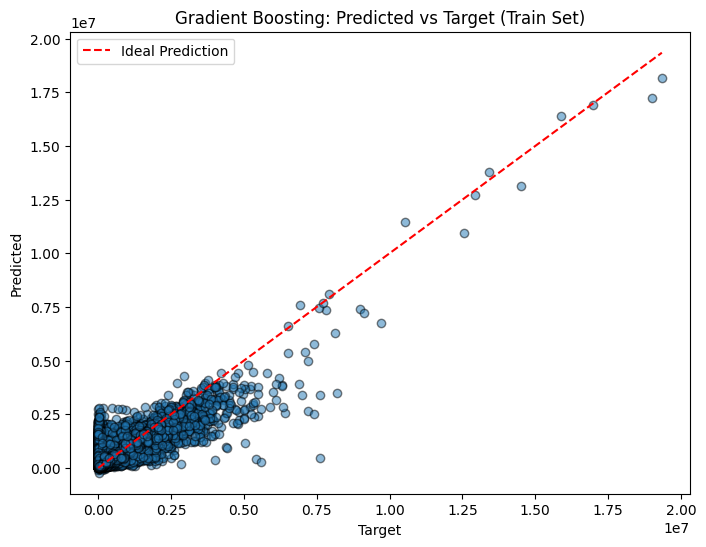

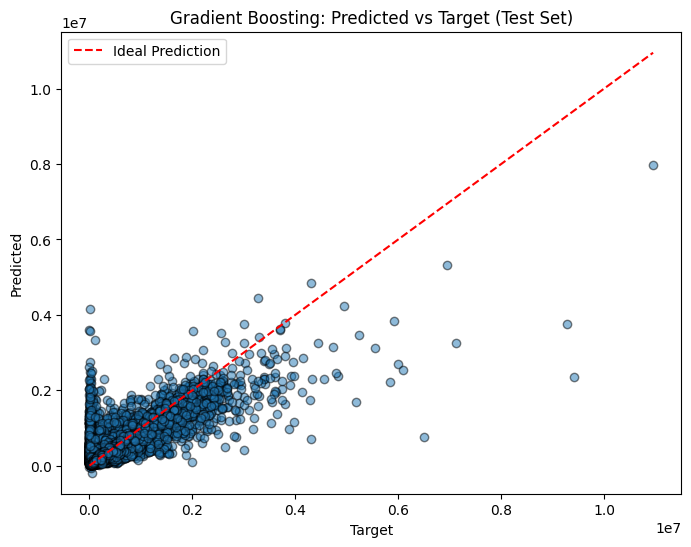

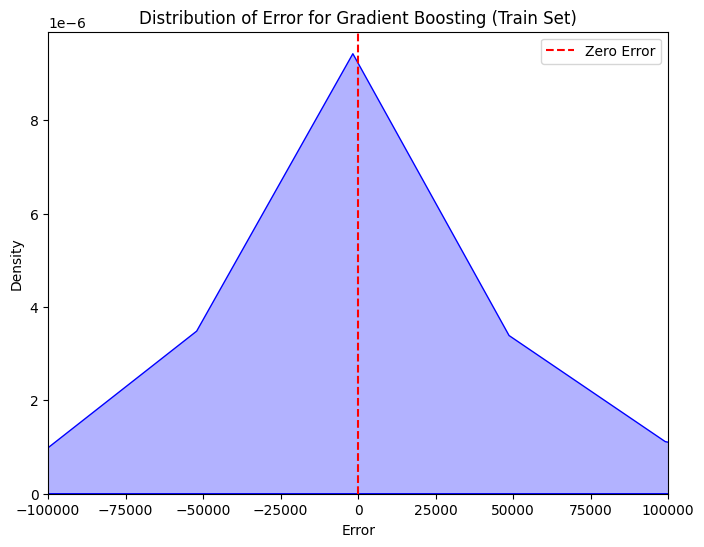

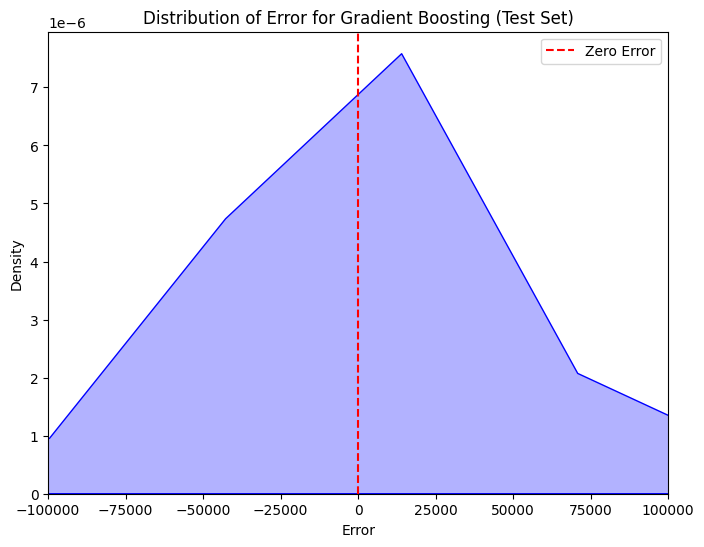

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Appliquez l'analyse d'erreur sur le modèle chargé
metrics = error_analysis(
    model=best_regression_model,
    X_train=X_train,
    y_train=y_train_regression,
    X_test=X_test,
    y_test=y_test_regression,
    feature_names=X_train.columns.tolist(),  # Utiliser les noms de colonnes si vous en avez
    train_model=False,  # Ne pas réentraîner le modèle, car il est déjà chargé
    prediction_title="Gradient Boosting: Predicted vs Target",
    error_title="Distribution of Error for Gradient Boosting"
)

## Analyse des erreurs par features numeriques

In [20]:


def analyze_errors(X_test, y_test, model, feature_names, numerical_features=None, verbose=True):
    """
    Fonction pour analyser les erreurs du modèle en fonction des prédictions et des caractéristiques numériques,
    en affichant des graphiques de distribution des erreurs et des statistiques descriptives des erreurs.

    Parameters:
    -----------
    X_test : pd.DataFrame
        Ensemble de données de test.
    y_test : pd.Series or np.array
        Cibles réelles de l'ensemble de test.
    model : object
        Modèle de machine learning déjà entraîné.
    feature_names : list
        Liste des noms des caractéristiques à utiliser pour les prédictions.
    numerical_features : list, optional
        Liste des caractéristiques numériques pour lesquelles vous souhaitez analyser les erreurs.
    verbose : bool, optional
        Si True, affiche les statistiques des erreurs.

    Returns:
    --------
    None
    """
    # Prédictions et calcul des erreurs
    y_test_pred = model.predict(X_test[feature_names])
    errors_test = y_test - y_test_pred
    X_test_copy = X_test.copy()
    X_test_copy["error"] = errors_test

    # --- Analyse des caractéristiques numériques et des erreurs ---
    if numerical_features:
        for feature in numerical_features:
            plt.figure(figsize=(10, 10))
             # Paramétrer les styles de seaborn
            sns.set(style="whitegrid")
            sns.scatterplot(x=feature, y="error", data=X_test_copy)
            plt.ylim(X_test_copy["error"].min() - 1000, X_test_copy["error"].max() + 1000)
            plt.title(f"Error Distribution per {feature}")
            plt.xlabel(feature)
            plt.ylabel("Error")
            plt.show()

    # --- Affichage des statistiques des erreurs ---
    if verbose:
        print("\nError Statistics:")
        print(X_test_copy["error"].describe().apply(lambda x: format(x, ".2f")))


/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


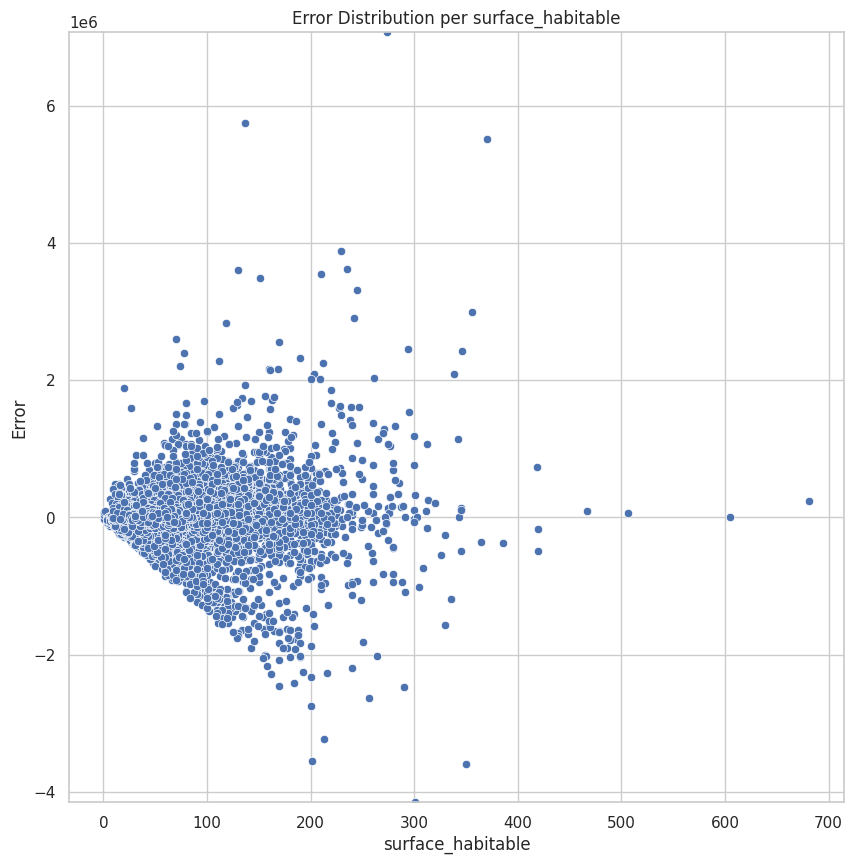

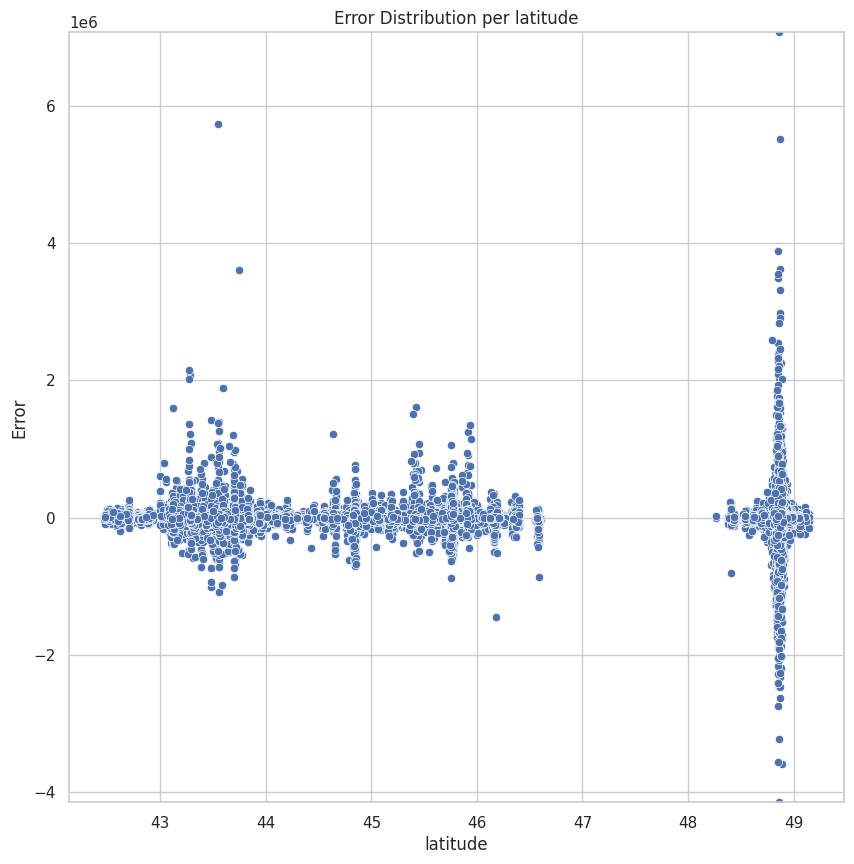

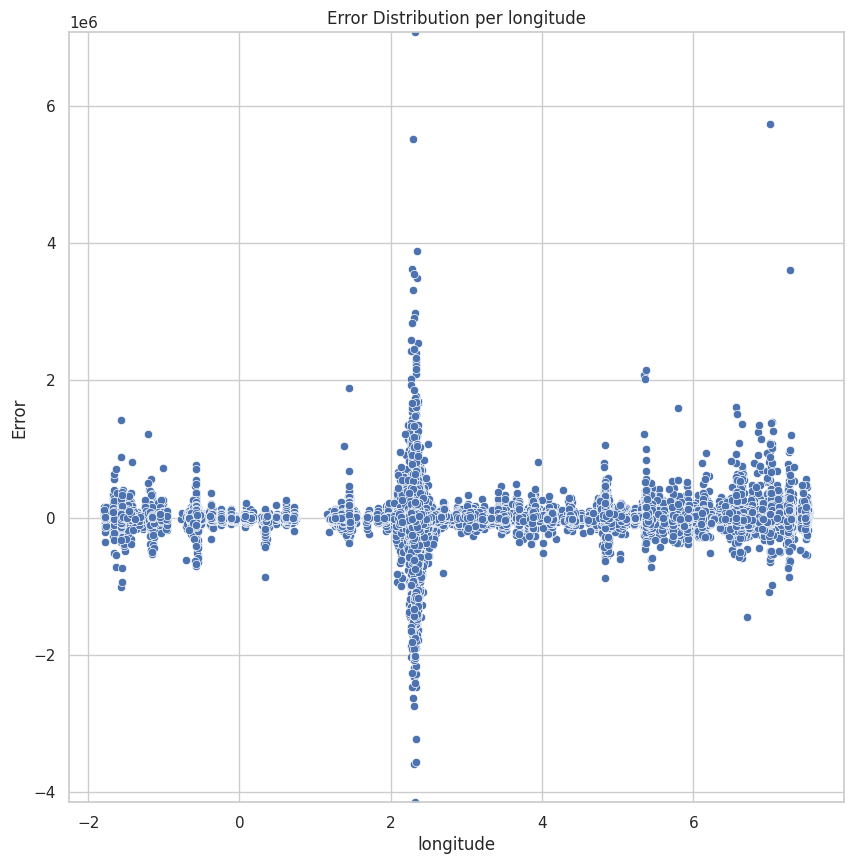

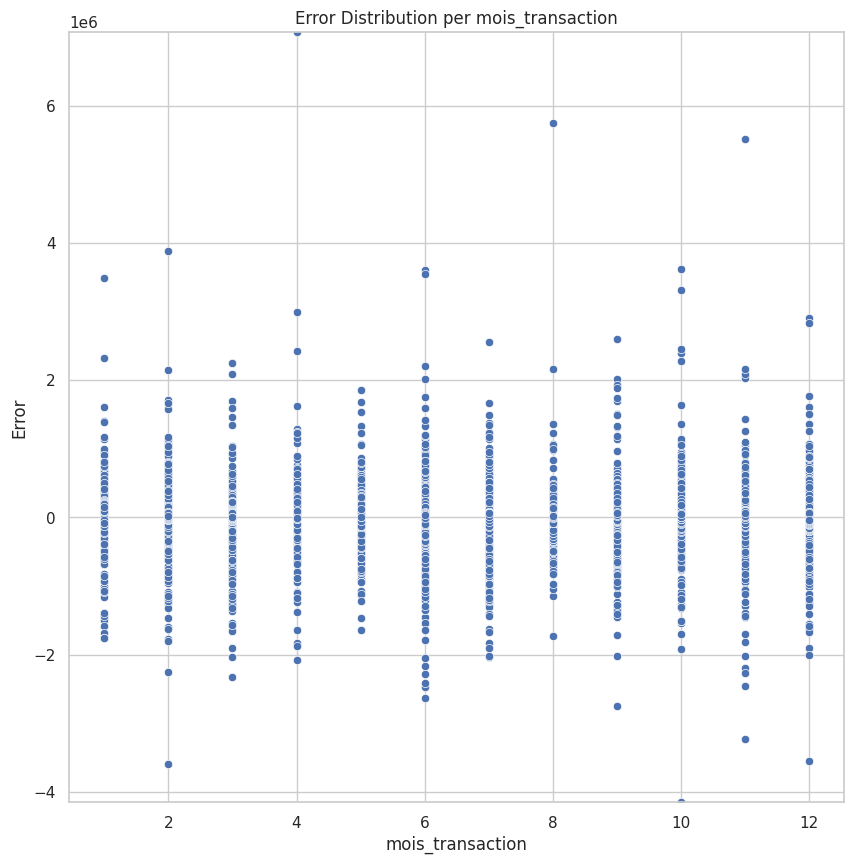

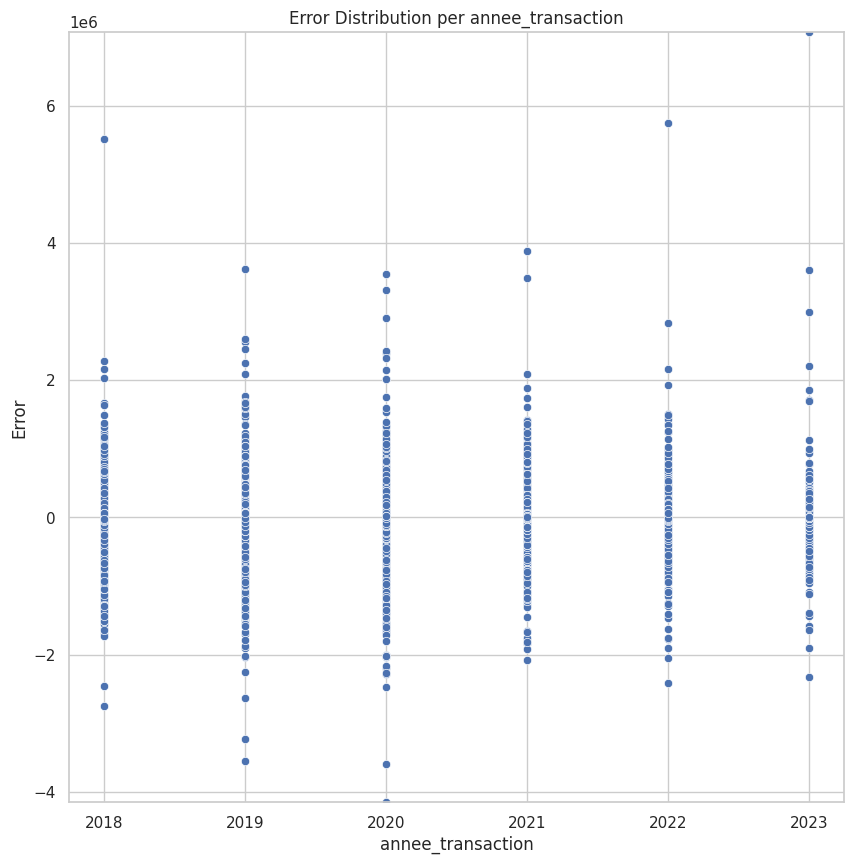

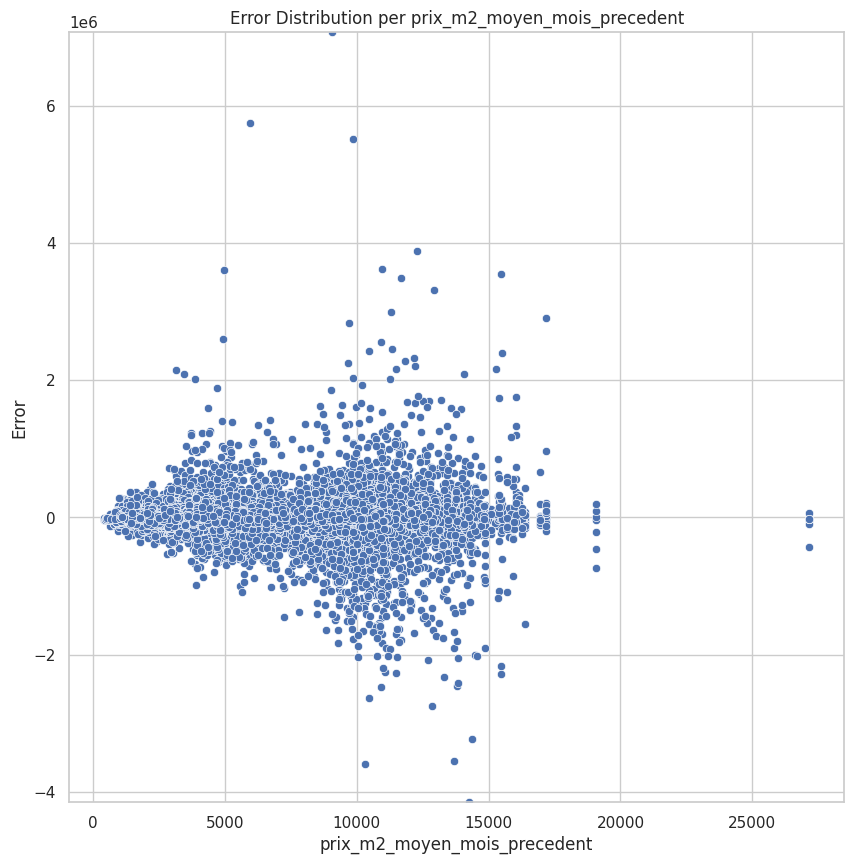

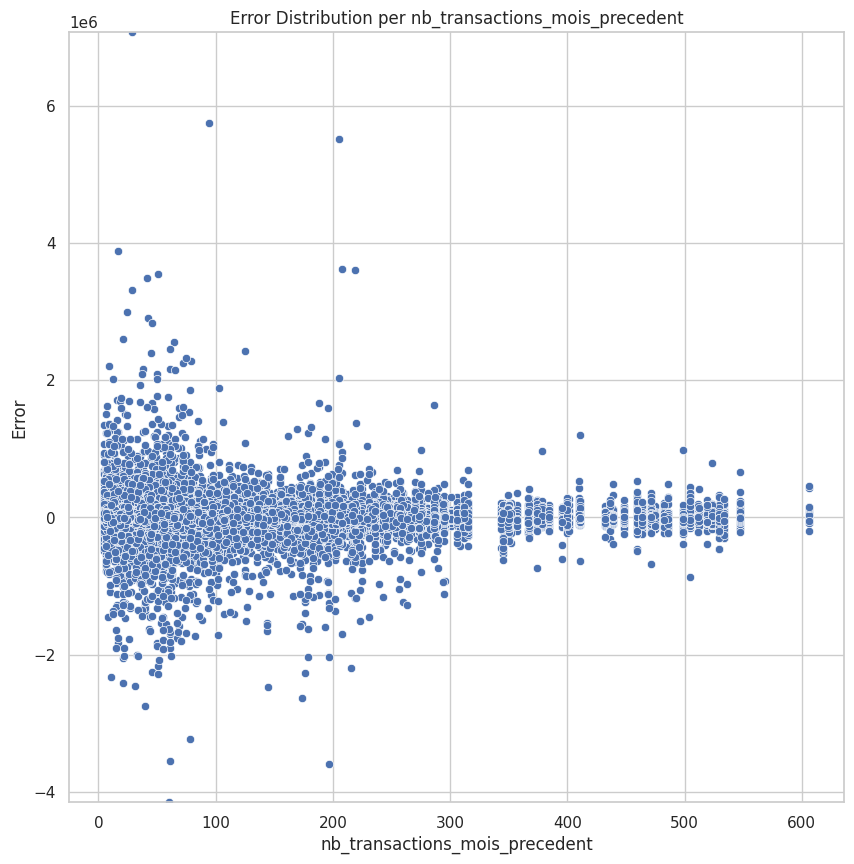


Error Statistics:
count       93623.00
mean          134.59
std        139899.23
min      -4146569.60
25%        -30159.78
50%         -2090.75
75%         30228.23
max       7071383.71
Name: error, dtype: object


In [22]:
analyze_errors(
    model=best_regression_model,  # Votre modèle entraîné
    X_test=X_test,             # Données de test
    y_test=y_test_regression,             # Cibles de test
    feature_names= X_train.columns.tolist(),  # Liste des noms des features utilisées pour la prédiction
    numerical_features=numerical_features,  # Liste des features numériques à analyser
    verbose=True               # Afficher les statistiques des erreurs
)

In [21]:
def get_X_y_particular_feature_value(X, y, feature_col, value):
        """
        Filtrer le jeu de données pour les lignes où une caractéristique catégorielle
        correspond à une valeur donnée.

        Paramètres:
        -----------
        X : pd.DataFrame
            Données des caractéristiques.
        y : pd.Series
            Cibles des données.
        feature_col : str
            Nom de la caractéristique catégorielle à filtrer.
        value : int ou float
            Valeur pour filtrer la caractéristique catégorielle.

        Retourne:
        --------
        tuple : (X filtré, y filtré)
        """
        X_copy = X.copy()
        X_copy["target"] = y
        X_filtered = X_copy[X_copy[feature_col] == value]
        return X_filtered.drop(["target"], axis=1), X_filtered["target"]


## Analyse des erreurs par catégories

In [22]:
from joblib import load

# Charger l'encodeur depuis le fichier
nom_region_encoder = load('../preprocessing/encoders/nom_region_encoder.joblib')
type_batiment_encoder = load('../preprocessing/encoders/type_batiment_encoder.joblib')

In [23]:
from sklearn.preprocessing import OneHotEncoder
from typing import Dict


def inverse_onehot_encoding(df: pd.DataFrame, column: str, encoder_dict: Dict[str, OneHotEncoder]) -> pd.DataFrame:
    """
    Inverse le One-Hot Encoding d'une colonne pour récupérer les catégories d'origine.

    Args:
        df (pd.DataFrame): DataFrame contenant les colonnes encodées.
        column (str): Nom de la colonne d'origine à réencoder.
        encoder_dict (Dict[str, OneHotEncoder]): Dictionnaire contenant la colonne et son encodeur.

    Returns:
        pd.DataFrame: DataFrame avec la colonne inversée à ses valeurs d'origine.
    """
    # Vérifier que l'encodeur pour la colonne existe dans le dictionnaire
    if column not in encoder_dict:
        raise ValueError(f"Aucun encodeur trouvé pour la colonne '{column}' dans le dictionnaire.")

    # Récupérer l'encodeur
    encoder = encoder_dict[column]

    # Extraire les colonnes encodées correspondant à cette colonne
    encoded_columns = encoder.get_feature_names_out([column])

    # Sélectionner les colonnes encodées dans le DataFrame
    encoded_df = df[encoded_columns]

    # Inverser le One-Hot Encoding pour récupérer les valeurs d'origine
    original_values = encoder.inverse_transform(encoded_df)

    # Ajouter la colonne originale au DataFrame (aplatissement en 1D)
    df[column] = original_values.ravel()

    # Supprimer les colonnes encodées
    df = df.drop(columns=encoded_columns)

    return df

In [24]:
X_test_categorical_analysis = X_test.copy()
# Inversion du One-Hot Encoding
X_test_one_hot_inverted = inverse_onehot_encoding(X_test_categorical_analysis, 'type_batiment', type_batiment_encoder)

X_test_one_hot_inverted = inverse_onehot_encoding( X_test_categorical_analysis, 'nom_region', nom_region_encoder)
X_test_one_hot_inverted.head()

,vefa,surface_habitable,latitude,longitude,mois_transaction,annee_transaction,prix_m2_moyen_mois_precedent,nb_transactions_mois_precedent,ville_demandee,type_batiment_Maison,type_batiment,nom_region
176605,0,61,45.438296,4.389209,3,2021,1054.82,130.0,1,0,Appartement,Auvergne-Rhône-Alpes
123391,0,35,44.824960,-0.597963,2,2019,4747.21,125.0,1,0,Appartement,Nouvelle-Aquitaine
342233,0,87,48.753156,2.634175,6,2020,3372.36,5.0,0,1,Maison,Île-de-France
147447,0,31,43.608599,3.874839,12,2020,3069.09,98.0,1,0,Appartement,Occitanie
185644,0,34,43.382322,-1.650237,2,2020,5613.85,15.0,0,0,Appartement,Nouvelle-Aquitaine


In [25]:


def plot_error_boxplot_with_predictions(model, X_test, y_test, df,categorical_features):
    """
    Calcule les erreurs de prédiction, ajoute la colonne 'error' dans X_test,
    puis crée un boxplot des erreurs par rapport à chaque caractéristique catégorielle spécifiée.

    Parameters:
    -----------
    model : object
        Modèle de machine learning qui a été entraîné.
    X_test : pd.DataFrame
        Ensemble de test avec les caractéristiques.
    y_test : pd.Series
        Valeurs réelles pour l'ensemble de test.
    categorical_features : list
        Liste des caractéristiques catégorielles pour lesquelles un boxplot des erreurs sera tracé.
    """
    # Prédictions et calcul des erreurs
    y_test_pred = model.predict(X_test)
    errors_test = y_test - y_test_pred
    df_copy = df.copy()
    df_copy["error"] = errors_test  # Ajout de la colonne des erreurs

    # Création des boxplots pour chaque caractéristique catégorielle
    for feature in categorical_features:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df_copy[feature], y=df_copy["error"])
        plt.ylabel("Error")
        plt.xlabel(feature)
        plt.xticks(rotation=70)
        plt.title(f"Boxplot of Error vs {feature}")
        plt.show()


In [26]:
categorical_features_updated=  X_test_one_hot_inverted.select_dtypes(exclude=['float','int']).columns.to_list()
# Ajouter la colonne 'vefa' si elle n'est pas déjà incluse
if 'vefa' in X_test_one_hot_inverted.columns and 'vefa' not in categorical_features_updated:
    categorical_features_updated.append('vefa')
# Ajouter la colonne 'ville_demandee' si elle n'est pas déjà incluse
if 'ville_demandee' in X_test_one_hot_inverted.columns and 'ville_demandee' not in categorical_features_updated:
    categorical_features_updated.append('ville_demandee')

/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


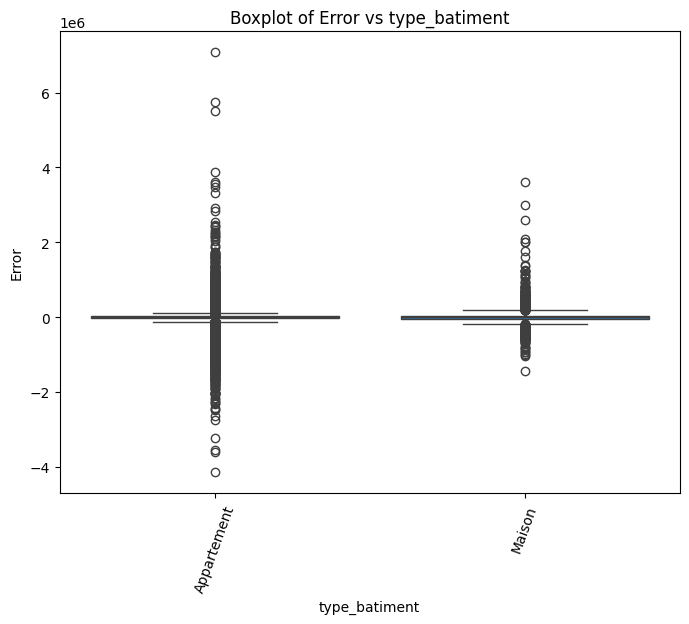

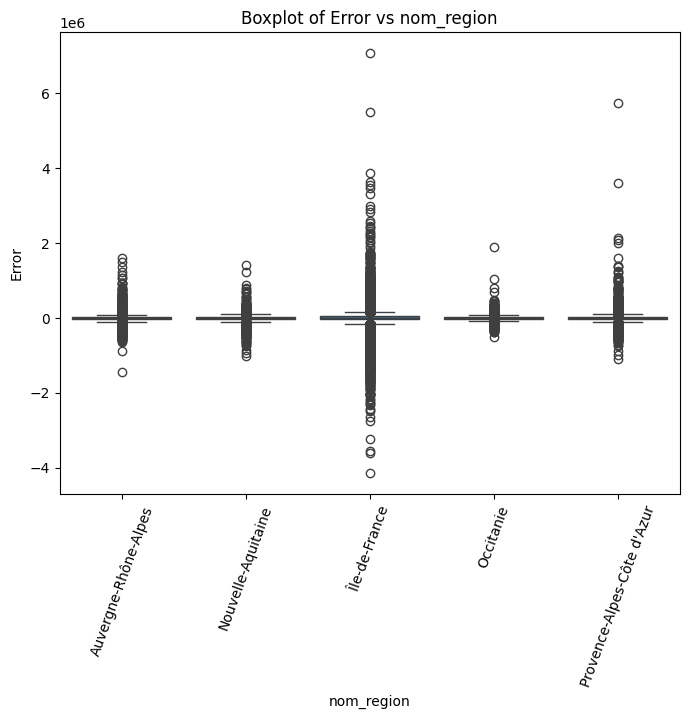

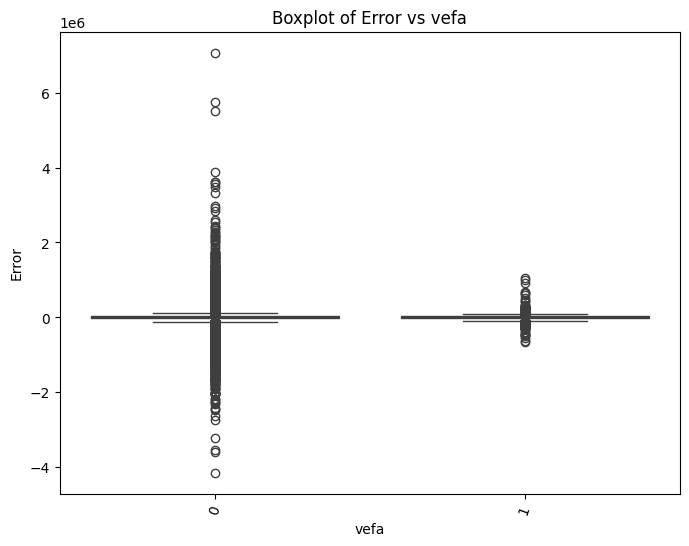

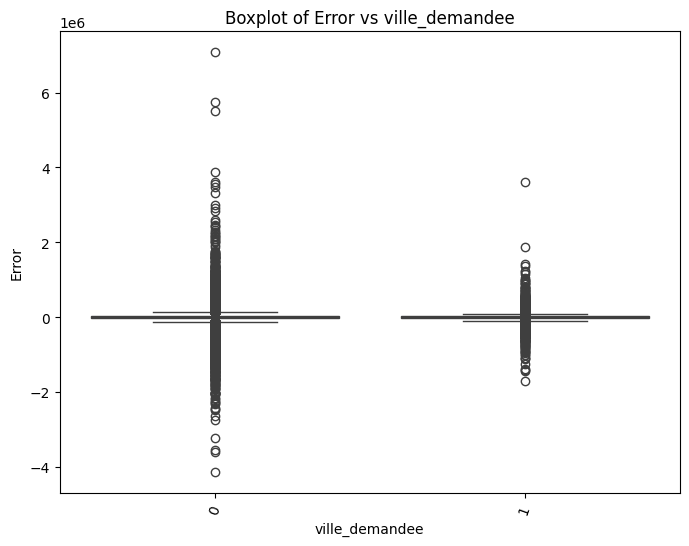

In [27]:
plot_error_boxplot_with_predictions(best_regression_model, X_test, y_test_regression,X_test_one_hot_inverted, categorical_features_updated)

## Analyse des erreurs par region

In [28]:
def plot_regression_predictions_by_category(model, X_test, y_test, df, categorical_feature, title):
    """
    Affiche des prédictions contre les cibles pour chaque valeur d'une caractéristique catégorielle.
    Crée un graphique de type 'scatter plot' pour chaque catégorie.

    Parameters:
    -----------
    model : object
        Modèle de machine learning qui a été entraîné.
    X_test : pd.DataFrame
        Ensemble de test avec les caractéristiques.
    y_test : pd.Series
        Valeurs réelles pour l'ensemble de test.
    df : pd.DataFrame
        DataFrame avec la colonne catégorielle spécifiée (par ex. 'nom_region').
    categorical_feature : str
        Le nom de la caractéristique catégorielle pour laquelle les graphiques doivent être générés.
    title : str
        Titre pour le graphique.
    """
    # Prédictions du modèle
    y_test_pred = model.predict(X_test)

    # Ajouter la prédiction et la cible au DataFrame
    df_copy = df.copy()
    df_copy["predicted"] = y_test_pred
    df_copy["true"] = y_test

    # Générer un scatter plot pour chaque catégorie dans la caractéristique spécifiée
    unique_values = df_copy[categorical_feature].unique()

    for value in unique_values:
        # Filtrer les données pour la catégorie actuelle
        category_data = df_copy[df_copy[categorical_feature] == value]

        # Tracer le scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(category_data["true"], category_data["predicted"], alpha=0.5, edgecolors="k")
        plt.plot(
            [min(y_test), max(y_test)],
            [min(y_test), max(y_test)],
            color="red",
            linestyle="--",
            label="Ideal Prediction",
        )
        plt.xlabel("Target")
        plt.ylabel("Predicted Target")
        plt.title(f"{title} - {categorical_feature}: {value}")
        plt.legend()
        plt.show()


/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


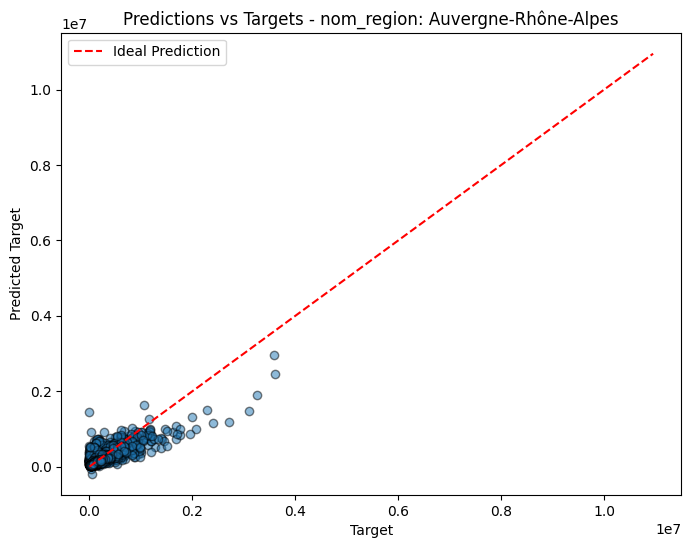

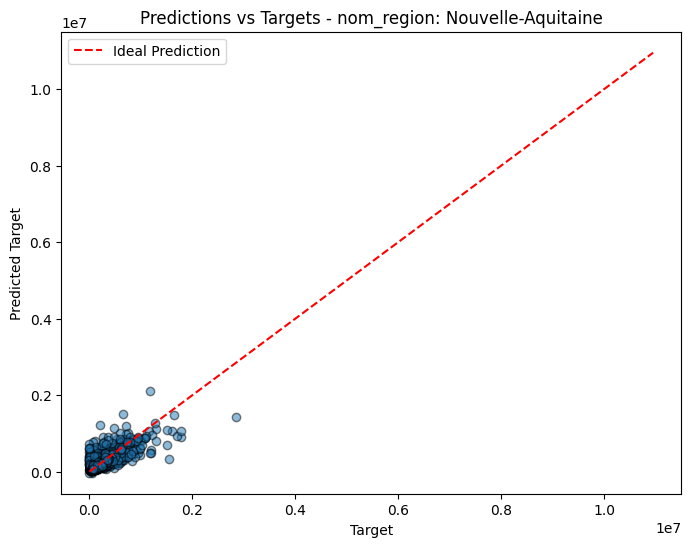

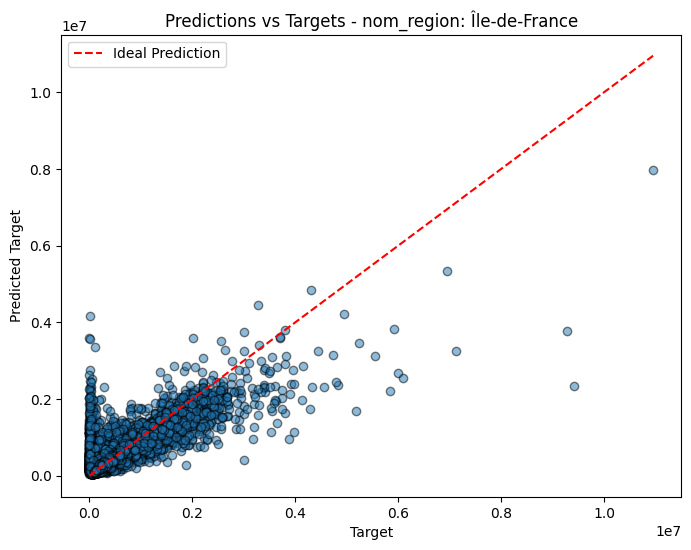

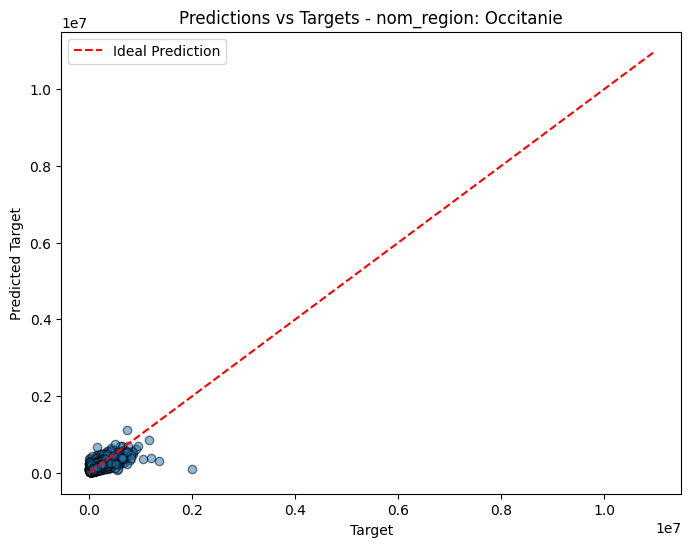

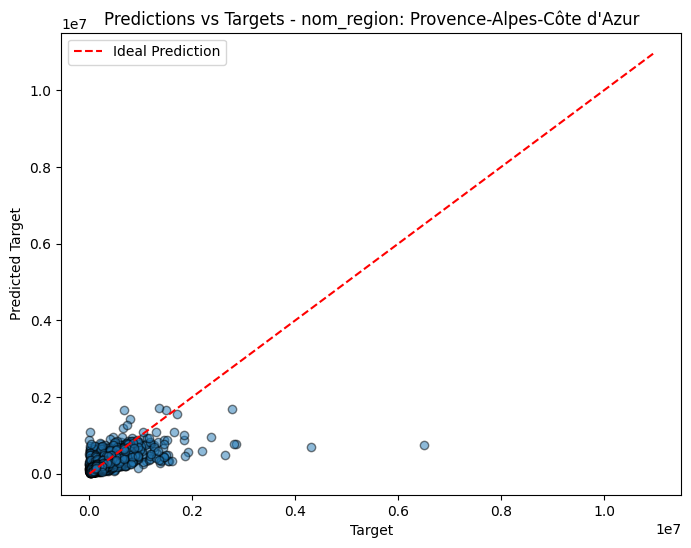

In [29]:
plot_regression_predictions_by_category(best_regression_model, X_test, y_test_regression,X_test_one_hot_inverted,categorical_feature="nom_region", title="Predictions vs Targets")

In [39]:
X_train.columns

Index(['vefa', 'surface_habitable', 'latitude', 'longitude',
       'mois_transaction', 'annee_transaction', 'prix_m2_moyen_mois_precedent',
       'nb_transactions_mois_precedent', 'ville_demandee',
       'type_batiment_Maison', 'nom_region_Nouvelle-Aquitaine',
       'nom_region_Occitanie', 'nom_region_Provence-Alpes-Côte d'Azur',
       'nom_region_Île-de-France'],
      dtype='object')

In [30]:
# Séparer les maisons et les appartements
maisons_data = X_train[X_train['type_batiment_Maison'] == 1]
appartements_data = X_train[X_train['type_batiment_Maison'] == 0]

In [31]:
# Filtrer y_train de manière cohérente
y_maisons = y_train_regression[X_train['type_batiment_Maison'] == 1]
y_appartements = y_train_regression[X_train['type_batiment_Maison'] == 0]

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor

# Configuration des paramètres spécifiques au GradientBoostingRegressor
model_params = {
    "n_estimators": 150,
    "learning_rate": 0.07,
    "max_depth": 5,
    "min_samples_split": 4,
    "min_samples_leaf": 2,
    "subsample": 0.9,
    "random_state": 42
}

# Initialisation du modèle
gradient_boosting_model = GradientBoostingRegressor(**model_params)

# Configuration des tags pour MLflow
tags = {
    "Experiment_Type": "models_comparison",
    "Phase": "baseline",
    "Model_Type": "Gradient Boosting Regressor",
    "Task": "Regression",
    "Run_Type": "Tunned",
    "Solver": "Gradient Boosting",
    "Dataset": "maisons_data",
    "CV_Method": "TimeSeriesSplit",
    "CV_Folds": 5,
}

# Validation croisée
cross_val_type = TimeSeriesSplit(n_splits=5)
scoring_metrics = ["neg_root_mean_squared_error", "neg_mean_absolute_error", "r2"]

# Exécution du modèle avec MLflow
run_name = "gradient_boosting_regressor_run_appartement_data"

scores_dict = train_and_log_model_with_mlflow(
    model=gradient_boosting_model,
    X_train=appartements_data,
    y_train=y_appartements,  # Variable cible pour la régression
    experiment_name="regression_models",
    run_name=run_name,
    model_params=model_params,
    tags=tags,
    cross_val_type=cross_val_type,
    scoring_metrics=scoring_metrics,
)

print(f"Scores obtenus avec GradientBoostingRegressor : {scores_dict}")


In [35]:
train_columns = X_train.columns
train_columns

Index(['vefa', 'surface_habitable', 'latitude', 'longitude',
       'mois_transaction', 'annee_transaction', 'prix_m2_moyen_mois_precedent',
       'nb_transactions_mois_precedent', 'ville_demandee',
       'type_batiment_Maison', 'nom_region_Nouvelle-Aquitaine',
       'nom_region_Occitanie', 'nom_region_Provence-Alpes-Côte d'Azur',
       'nom_region_Île-de-France'],
      dtype='object')

In [37]:
X_test.columns


Index(['vefa', 'surface_habitable', 'latitude', 'longitude',
       'mois_transaction', 'annee_transaction', 'prix_m2_moyen_mois_precedent',
       'nb_transactions_mois_precedent', 'ville_demandee',
       'type_batiment_Maison', 'nom_region_Nouvelle-Aquitaine',
       'nom_region_Occitanie', 'nom_region_Provence-Alpes-Côte d'Azur',
       'nom_region_Île-de-France'],
      dtype='object')

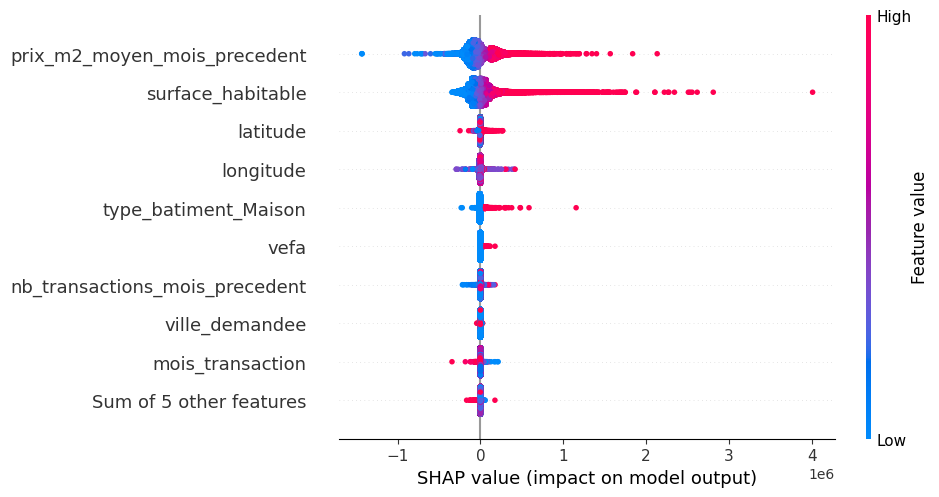

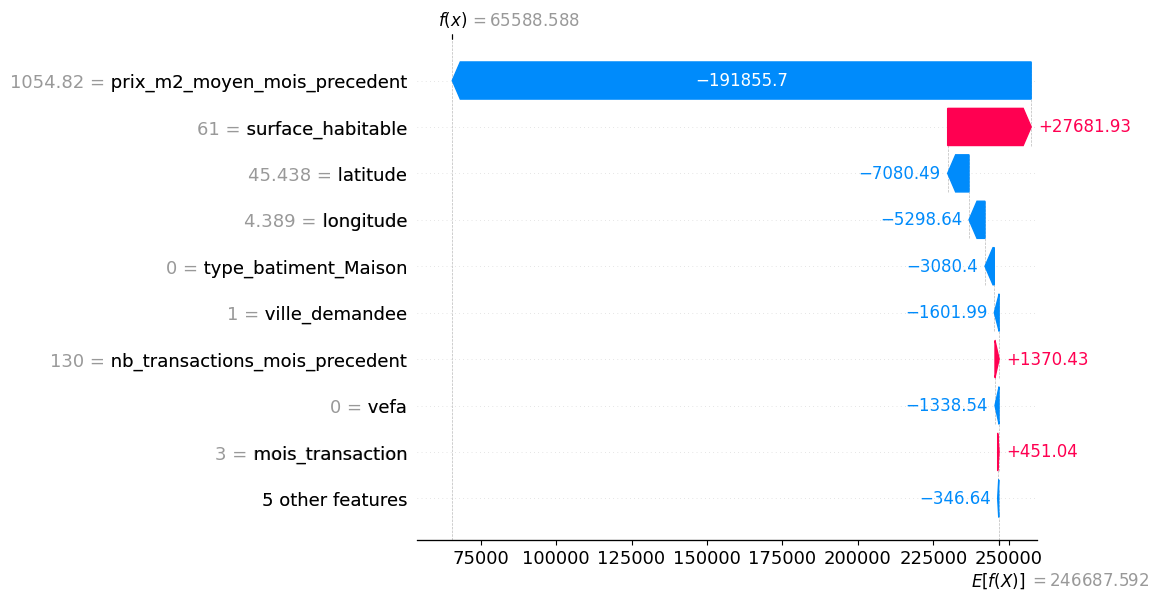

In [ ]:
import shap


# Appliquer SHAP pour un modèle GradientBoostingRegressor déjà entraîné (par exemple, gradient_boosting_model)
explainer = shap.Explainer(best_regression_model)  # Créer l'explainer pour le modèle
shap_values = explainer(X_test[train_columns])  # Calculer les valeurs SHAP pour les données d'entraînement

# Visualisation des valeurs SHAP globales (importance des caractéristiques)
shap.plots.beeswarm(shap_values)

# Visualisation d'une instance particulière
shap.initjs()  # Initialiser JavaScript pour l'affichage interactif
shap.plots.waterfall(shap_values[0])  # Visualisation pour la première instance


In [17]:
shap.force_plot(shap_values[10])